<a href="https://colab.research.google.com/github/NihaarikaAgarwal/CorrectiveRAG/blob/main/CRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
!pip install langchain==0.2.0
#!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1
!pip install langchain-chroma==0.1.1
!pip install huggingface_hub
!pip install --force-reinstall chromadb==0.5.23 tokenizers==0.20.3 transformers==4.29.2

  Using cached tenacity-8.5.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
Using cached tenacity-8.5.0-py3-none-any.whl (28 kB)
Using cached packaging-24.2-py3-none-any.whl (65 kB)
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.1.2
    Uninstalling tenacity-9.1.2:
      Successfully uninstalled tenacity-9.1.2
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.4.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.10.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompa

  Using cached chromadb-0.5.23-py3-none-any.whl.metadata (6.8 kB)
  Using cached tokenizers-0.20.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached transformers-4.29.2-py3-none-any.whl.metadata (112 kB)
  Using cached build-1.2.2.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached pydantic-2.11.5-py3-none-any.whl.metadata (67 kB)
  Using cached chroma_hnswlib-0.7.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (252 bytes)
  Using cached fastapi-0.115.12-py3-none-any.whl.metadata (27 kB)
  Using cached uvicorn-0.34.2-py3-none-any.whl.metadata (6.5 kB)
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached onnxruntime-1.22.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (4.5 kB)
  Using cached opentelemetry_api-1.33.1-py3-none-any.whl.metadata (1.6 kB)
  Using c

In [75]:
 !pip install -q --force-reinstall chromadb==0.4.24 transformers==4.28.1 tokenizers==0.13.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.7/96.7 kB 2.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
langchain-core 0.2.43 requires packaging<25,>=23.2, but you have packaging 25.0 which is incompatible.
langchain-core 0.2.43 requires tenacity!=8.4.0,<9.0.0,>=8.1.0, but you have tenacity 9.1.2 which is incompatible.
scipy 1.10.1 requires numpy<1.27.0,>=1.19.5, but you have numpy 2.2.6 which is incompatible.
langchain-chroma 0.1.1 requires numpy<2,>=1, but you have numpy 2.2.6 which is incompatible.
langchain 0.2.0 requires numpy<2,>=1, but you have numpy 2.2.6 which is incompatible.
langchain 0.2.0 requires tenacity<9.0.0,>=8.1.0, but you have tenacity 9.1.2 which is incompatible.
langchain-community 0.2.0 requires numpy<2,>=1, but you have numpy 2.2.6 which is incompatible.
la

In [14]:
from getpass import getpass
from huggingface_hub import InferenceClient
huggingface_key = getpass('Enter your hugging face API Key:')

Enter your hugging face API Key:··········


In [15]:
TAVILY_API_KEY = getpass('Enter your Tavily API Key:')

Enter your Tavily API Key:··········


In [ ]:
# from getpass import getpass
# openai_key = getpass('Enter your OpenAI API Key:')

Enter your OpenAI API Key:··········


In [16]:
import os
os.environ['HUGGINGFACEHUB_API_TOKEN'] = huggingface_key
#os.environ['OPENAI_API_KEY'] = openai_key
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

Build search index for wikipedia data

In [ ]:
# from langchain_openai import OpenAIEmbeddings
# openai_embedding = OpenAIEmbeddings(model = 'text-embedding-3-small')

In [79]:
!pip install sentence-transformers

  Using cached transformers-4.52.3-py3-none-any.whl.metadata (40 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached transformers-4.52.3-py3-none-any.whl (10.5 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Attempting uninstall: tokenizers
    Found existing 

In [4]:
!pip install scipy==1.10.1 --force-reinstall

  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.1 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.2.0 requires tenacity<9.0.0,>=8.1.0, but you have tenacity 9.1.2 which is incompatible.
langchain-community 0.2.0

In [ ]:
!pip install sentence-transformers

In [17]:
from langchain.embeddings import HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [18]:
import json
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

wikipedia_filepath = '/content/sample_data/simplewiki-2020-11-01.jsonl'
docs = []

with open(wikipedia_filepath, 'r', encoding='utf-8') as fIn:
    for line in fIn:
        data = json.loads(line.strip())
        # only first 3 paras
        text = ''.join(data.get('paragraphs', [])[:3])
        metadata = {
            "title": data.get('title'),
            "article_id": data.get('id')
        }
        docs.append({'metadata': metadata, 'data': text})

# taking subset to keep small in size
docs = [doc for doc in docs if 'india' in doc['data'].lower()]

# create docs
langchain_docs = [
    Document(page_content=doc['data'], metadata=doc['metadata']) for doc in docs
]

# chunk docs
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
chunked_docs = splitter.split_documents(langchain_docs)

for i, chunk in enumerate(chunked_docs[:3]):
    print(f"Chunk {i+1}:\n", chunk.page_content[:500], "\n")


Chunk 1:
 The term Far East means countries of East Asia. It became used in the English language during the period of the British Empire for lands to the east of British India.Before World War I, the "Near East" meant relatively nearby lands of the Ottoman Empire, "Middle East" northwestern South Asia and Central Asia, and "Far East" countries along the western Pacific Ocean and countries along the eastern Indian Ocean. Many European languages have analogous terms, such as the French ', Spanish ', Portugu 

Chunk 2:
 A hair iron or hair tong is something people use to change the shape of the hair by heating it. There are three types of hair iron:In 1872, Marcel Grateau (a Parisian) used heated rods to curl or style hair.In 1893, Ada Harris, a school teacher from Indianapolis, applied for a patent for the hair straightener. The hair straightener was a device “heated like a curling iron” with two flat faces held together by a hinge . It was said that when the faces press the hair, it wil

In [7]:
len(chunked_docs)

5642

In [8]:
chunked_docs[:3]

[Document(metadata={'title': 'Far East', 'article_id': '85954'}, page_content='The term Far East means countries of East Asia. It became used in the English language during the period of the British Empire for lands to the east of British India.Before World War I, the "Near East" meant relatively nearby lands of the Ottoman Empire, "Middle East" northwestern South Asia and Central Asia, and "Far East" countries along the western Pacific Ocean and countries along the eastern Indian Ocean. Many European languages have analogous terms, such as the French \', Spanish \', Portuguese \', German \', Italian \', and Dutch \'."Far East" is never used for the culturally Western nations of Australia and New Zealand, which lie even farther to the east of Europe than much of East Asia.'),
 Document(metadata={'title': 'Hair iron', 'article_id': '86329'}, page_content="A hair iron or hair tong is something people use to change the shape of the hair by heating it. There are three types of hair iron:In

In [ ]:
!pip install numpy==1.26.4 --force-reinstall

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.2.0 requires tenacity<9.0.0,>=8.1.0, but you have tenacity 9.1.2 which is incompatible.
langchain-community 0.2.0 requires tenacity<9.0.0,>=8.1.0, but you have tenacity 9.1.2 which is incompatible.
cvxpy 1.6.5 requires scipy>=1.11.0, but you have scipy 1.10.1 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
bigframes 2

In [19]:
import shutil

shutil.rmtree("content_db", ignore_errors=True)
print("Removed existing content_db before rebuild")

Removed existing content_db before rebuild


In [20]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from tqdm import tqdm
#vector db
#test_docs = chunked_docs[:1]
# remove duplicates
unique_docs = list({doc.page_content: doc for doc in chunked_docs}.values())
documents = list(tqdm(unique_docs, desc="Embedding Chunks"))
vectorstore = Chroma.from_documents(
    documents=unique_docs,
    collection_name='wikipedia_data_indexed',
    embedding=embedding_model,
    collection_metadata={"hnsw:space": "cosine"},
    persist_directory="content_db"
)


Embedding Chunks: 100%|██████████| 5642/5642 [00:00<00:00, 2907514.83it/s]


In [21]:
import os
print("Directory exists:", os.path.exists("content_db"))
print("Contents:", os.listdir("content_db"))

Directory exists: True
Contents: ['chroma.sqlite3', '398d000e-77cc-4111-8456-30312756119b']


In [22]:
import os

abs_path = os.path.abspath("content_db")
print("Chroma DB stored at:", abs_path)

Chroma DB stored at: /content/content_db


In [23]:
print(" Total docs in vectorstore:", len(vectorstore.get()))

 Total docs in vectorstore: 6


Retreival with similarity threshold



In [30]:
# vectorstore = Chroma(
#     collection_name='wikipedia_data_indexed',
#     embedding_function=embedding_model,
#     persist_directory="wikipedia_db"
# )
similarity_threshold = vectorstore.as_retriever(search_type='similarity_score_threshold', search_kwargs={"k" : 5,"score_threshold":0.3})

In [15]:
query = "what is the capital of India?"
top5_docs = similarity_threshold.invoke(query)
top5_docs

[Document(metadata={'article_id': '731169', 'title': 'Central India'}, page_content='Central India is an Indian region.Central India consists of two Indian states: Madhya Pradesh and Chhattisgarh. It shares a border with Rajasthan, Gujarat, Odisha, Jharkhand, Uttar Pradesh, Maharashtra and Telangana. Both the states are ruled by the Congress with Chief Ministers andThis map of India (press to open) shows all central Indian states in the colour pink. The larger one is Madhya Pradesh while the smaller one is Chhattisgarh.'),
 Document(metadata={'article_id': '22215', 'title': 'States and union territories of India'}, page_content='The Republic of India is divided into twenty-eight States,and eight union territories including the National Capital Territory.'),
 Document(metadata={'article_id': '21564', 'title': 'Chhattisgarh'}, page_content="Chhattisgarh is a state within the Republic of India. It occupies . In traditional Indian geography it falls under the East Indian zone.The capital a

In [16]:
for i, doc in enumerate(top5_docs):
    print(f"Doc {i+1}:\n{doc.page_content[:200]}")
    print("Metadata:", doc.metadata)
    print("-" * 40)

Doc 1:
Central India is an Indian region.Central India consists of two Indian states: Madhya Pradesh and Chhattisgarh. It shares a border with Rajasthan, Gujarat, Odisha, Jharkhand, Uttar Pradesh, Maharashtr
Metadata: {'article_id': '731169', 'title': 'Central India'}
----------------------------------------
Doc 2:
The Republic of India is divided into twenty-eight States,and eight union territories including the National Capital Territory.
Metadata: {'article_id': '22215', 'title': 'States and union territories of India'}
----------------------------------------
Doc 3:
Chhattisgarh is a state within the Republic of India. It occupies . In traditional Indian geography it falls under the East Indian zone.The capital at present is Raipur which would change to 'Naya Rai
Metadata: {'article_id': '21564', 'title': 'Chhattisgarh'}
----------------------------------------
Doc 4:
New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and 

In [ ]:
query = "what is Langraph"
top5_docs = similarity_threshold.invoke(query)
top5_docs

[Document(metadata={'article_id': '646696', 'title': 'Bengali script'}, page_content='The Bengali script or Bengali alphabet is used to write the Indian languages: Bengali (বাংলা), Assamese (অসমীয়া).'),
 Document(metadata={'article_id': '646696', 'title': 'Bengali script'}, page_content='The Bengali script or Bengali alphabet is used to write the Indian languages: Bengali (বাংলা), Assamese (অসমীয়া).'),
 Document(metadata={'article_id': '9594', 'title': 'History of graphic design'}, page_content='Graphics (from Greek ) are visual presentations on some surface, such as a wall, canvas, computer screen, paper, or stone. It includes everything that relates to creation of signs, charts, logos, graphs, drawings, symbols, geometric designs and so on.Graphic design is the art or profession of combining text and pictures in art, advertisements, publications, or websites. The aim of graphics is to brand, inform, and have a specific effect on its audience.Hundreds of graphic designs of animals w

create query retrieval grader

In [ ]:
!pip install ctransformers

In [24]:
from ctransformers import AutoModelForCausalLM

llm = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Mistral-7B-Instruct-v0.1-GGUF",
    model_file="mistral-7b-instruct-v0.1.Q4_K_M.gguf",
    model_type="mistral",
    max_new_tokens=128,
    context_length=4096,
    temperature=0
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
from typing import Any, List
from langchain_core.language_models import LLM

class CTransformersLLM(LLM):
    model: Any

    def _call(self, prompt: str, stop: List[str] = None) -> str:
        output = self.model(prompt)
        if stop:
            for s in stop:
                output = output.split(s)[0]
        return output

    @property
    def _identifying_params(self):
        return {"model": "ctransformers"}

    @property
    def _llm_type(self):
        return "ctransformers"


In [26]:
from pydantic import BaseModel, Field
from langchain.prompts import ChatPromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain.schema.runnable import Runnable

class GradeDocuments(BaseModel):
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

#llm = CTransformersLLM(model=llm)

SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
Respond in **valid JSON** ONLY and on a single line.
Your answer must be exactly one of these:
{{ "binary_score": "yes" }}
or
{{ "binary_score": "no" }}
Do not write anything else. No 'Grader:', no explanation."""

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", SYS_PROMPT),
    ("human", "Retrieved document: {document}\nUser question: {question}")
])


llm = CTransformersLLM(model=llm)
parser = PydanticOutputParser(pydantic_object=GradeDocuments)

doc_grader: Runnable = grade_prompt | llm | parser

In [27]:
import json
import re

def extract_json(text):
    match = re.search(r"\{.*?\}", text)
    if match:
        try:
            return json.loads(match.group())
        except json.JSONDecodeError:
            return None
    return None

In [28]:
def safe_invoke_with_json_extraction(chain, inputs):
    from langchain_core.exceptions import OutputParserException

    try:
        result = chain.invoke(inputs)
        return result.dict() if hasattr(result, "dict") else result
    except OutputParserException as e:
        raw = e.llm_output.strip()
        print("Parsing failed. Raw output:\n", raw)
        data = extract_json(raw)
        if data:
            return data
        else:
            return {"binary_score": "unclear"}

In [ ]:
response = safe_invoke_with_json_extraction(doc_grader, {
    "document": "India is a country in South Asia with a long cultural history.",
    "question": "Where is India located?"
})

print(" Binary Score:", response["binary_score"])


Parsing failed. Raw output:
 Grader: { "binary_score": "yes" }
 Binary Score: yes


In [31]:
query = "what is the capital of India?"
top5_docs = similarity_threshold.invoke(query)

for doc in top5_docs:
    print("Document:\n", doc.page_content)

    result = safe_invoke_with_json_extraction(doc_grader, {
        "question": query,
        "document": doc.page_content
    })

    print("GRADE:", result["binary_score"])
    print()


Document:
 Central India is an Indian region.Central India consists of two Indian states: Madhya Pradesh and Chhattisgarh. It shares a border with Rajasthan, Gujarat, Odisha, Jharkhand, Uttar Pradesh, Maharashtra and Telangana. Both the states are ruled by the Congress with Chief Ministers andThis map of India (press to open) shows all central Indian states in the colour pink. The larger one is Madhya Pradesh while the smaller one is Chhattisgarh.
Parsing failed. Raw output:
 Grader: { "binary_score": "no" }
GRADE: no

Document:
 The Republic of India is divided into twenty-eight States,and eight union territories including the National Capital Territory.
Parsing failed. Raw output:
 Grader: { "binary_score": "no" }
GRADE: no

Document:
 Chhattisgarh is a state within the Republic of India. It occupies . In traditional Indian geography it falls under the East Indian zone.The capital at present is Raipur which would change to 'Naya Raipur' near Raipur. It has eighteen districts: Raigarh

In [44]:
query = "what is Langraph?"
top5_docs = similarity_threshold.invoke(query)

for doc in top5_docs:
    print("Document:\n", doc.page_content)

    result = safe_invoke_with_json_extraction(doc_grader, {
        "question": query,
        "document": doc.page_content
    })

    print("GRADE:", result["binary_score"])
    print()

Document:
 The Bengali script or Bengali alphabet is used to write the Indian languages: Bengali (বাংলা), Assamese (অসমীয়া).
Parsing failed. Raw output:
 Grader: { "binary_score": "no" }
GRADE: no

Document:
 Graphics (from Greek ) are visual presentations on some surface, such as a wall, canvas, computer screen, paper, or stone. It includes everything that relates to creation of signs, charts, logos, graphs, drawings, symbols, geometric designs and so on.Graphic design is the art or profession of combining text and pictures in art, advertisements, publications, or websites. The aim of graphics is to brand, inform, and have a specific effect on its audience.Hundreds of graphic designs of animals were made by primitive people in Chauvet cave, in the south of France, about 30,000 BC. Also, similar art was done in the Lascaux cave, France, about 14,000 BC. The art of primitive hunters is found in the rocks of Bhimbetka in India, drawn earlier than 7000 BC. Aboriginal rock art in Kakadu N

<ipython-input-28-8b0cc36415f2>:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  return result.dict() if hasattr(result, "dict") else result


GRADE: no

Document:
 Dialogue or dialog is a shared inquiry or the art of thinking together. Dialogue is a rhetorical, literary and theatrical format. It means a written or spoken conversational exchange between two or more people.The historical origins of dialogue are in classical Greek and Indian literature.Dialogue is an element in the art of rhetoric.
Parsing failed. Raw output:
 Grader: { "binary_score": "no" }
GRADE: no

Document:
 Indian Paintbrush is a common name for different plants:
Parsing failed. Raw output:
 Grader: { "binary_score": "no" }
GRADE: no

Document:
 Devanāgarī (देवनागरी) is an abugida script used to write many North Indian languages, including Sanskrit, Hindi, Marathi, Sindhi, Bihari, Bhili, Konkani, Bhojpuri, Nepal Bhasa and Nepali from Nepal and sometimes Kashmiri. About a hundred smaller languages also use Devanāgarī.
Parsing failed. Raw output:
 Grader: { "binary_score": "no" }
GRADE: no



In [45]:
query = "who won the champions league in 2024?"
top5_docs = similarity_threshold.invoke(query)

for doc in top5_docs:
    print("Document:\n", doc.page_content)

    result = safe_invoke_with_json_extraction(doc_grader, {
        "question": query,
        "document": doc.page_content
    })

    print("GRADE:", result["binary_score"])
    print()

Document:
 The World Series in Major League Baseball, is when the best team from the American League (the winner of the American League Championship Series) and the best team from the National League (the winner of the National League Championship Series) keep playing games of baseball until one of the two teams wins four games total. The winners of the most recent World Series in 2019 were the Washington Nationals. They defeated the Houston Astros four games to three.The New York Yankees have 27 World Series championships, the most of any team. The Cleveland Indians currently hold the longest active drought, having last won the Series before expansion teams were formed. Recently, the three longest championship droughts were ended by the Boston Red Sox, Chicago White Sox, and the Chicago Cubs.
Parsing failed. Raw output:
 Grader: { "binary_score": "no" }
GRADE: no

Document:
 The Monaco Grand Prix (Grand Prix de Monaco) is a Formula One race held each year on the Circuit de Monaco. Run

<ipython-input-28-8b0cc36415f2>:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  return result.dict() if hasattr(result, "dict") else result


GRADE: no

Document:
 India national football team is the national football team of India. It has won the AFC challenge Cup in 2008 and ranks 150 in FIFA ranking (2014). The team is managed by Wim Koevermans. They have been runners up of Asian Nations Cup (1964). Their best result is to feature in the fourth olympic football tournament's finals in 1956.
Parsing failed. Raw output:
 
GRADE: unclear

Document:
 The history of chess goes back 2200 years. It was played in Chinese Warring Sates Period about 200BC, called XiangQi. Modern International Chess game though originated in northern India in the 6th century (which shares quite a few common Characteristics with the Chinese creation) and spread to Persia. When the Arabs conquered Persia, chess was taken up by the Muslim world and subsequently, through the Moorish conquest of Spain, spread to Southern Europe. But in early Russia, the game came directly from the Khanates (muslim territories) to the south.In Europe, the moves of the piec

<ipython-input-28-8b0cc36415f2>:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  return result.dict() if hasattr(result, "dict") else result


build qa rag

In [ ]:
from ctransformers import AutoModelForCausalLM

llm_raw = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Mistral-7B-Instruct-v0.1-GGUF",
    model_file="mistral-7b-instruct-v0.1.Q4_K_M.gguf",
    model_type="mistral",
    max_new_tokens=512,
    temperature=0.0,
    context_length=4096
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from langchain_core.language_models import LLM
from typing import Any, List

class CTransformersLLM(LLM):
    model: Any

    def _call(self, prompt: str, stop: List[str] = None) -> str:
        output = self.model(prompt)
        if stop:
            for s in stop:
                output = output.split(s)[0]
        return output

    @property
    def _identifying_params(self):
        return {"model": "ctransformers"}

    @property
    def _llm_type(self):
        return "ctransformers"

llm = CTransformersLLM(model=llm_raw)

In [32]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from operator import itemgetter

QA_PROMPT = """You are an assistant for question answering tasks. Use the following pieces of retrieved context to answer the question.
If no context is present or you don't know the answer, just say "I don't know".
Do not make up the answer.
Question: {question}
Context: {context}
Answer:"""

prompt_template = ChatPromptTemplate.from_template(QA_PROMPT)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

qa_rag_chain = (
    {
        "context": itemgetter("context") | RunnableLambda(format_docs),
        "question": itemgetter("question")
    }
    | prompt_template
    | llm
    | StrOutputParser()
)

In [24]:
from langchain_core.documents import Document

query = "What is the capital of India?"
retrieved_docs = [
    Document(page_content="New Delhi is the capital of India."),
    Document(page_content="India is a country in South Asia."),
]

result = qa_rag_chain.invoke({
    "question": query,
    "context": retrieved_docs
})

print("Answer:", result)

Answer:  New Delhi


In [ ]:
query = "What is the capital of India?"

top5_docs = similarity_threshold.invoke(query)

result = qa_rag_chain.invoke({
    'question': query,
    'context': top5_docs
})

print("Answer:", result)

Answer:  The capital of India is New Delhi.


create query rewriter

In [33]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

SYS_PROMPT = """You are a question rewriter. Your task is to:
1. Convert the following input question into a better version optimized for web search.
2. When rewriting, understand the semantic intent of the original question.
3. Return only the rewritten question and nothing else.
If the question is already optimal, return it unchanged."""

rewrite_prompt = ChatPromptTemplate.from_messages([
    ("system", SYS_PROMPT),
    ("human", "Here is the initial question: {question}. Rewrite it.")
])

question_rewriter = rewrite_prompt | llm | StrOutputParser()


In [ ]:
query = "Who won champions league in 2024?"

rewritten = question_rewriter.invoke({"question": query})
print("Rewritten Question:", rewritten)


Rewritten Question: 
AI: What was the winner of the Champions League in 2024?


load web search tool

In [34]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced" )

results = tavily_tool.invoke("What is the capital of India?")
#print(results)


[{'url': 'https://www.usatoday.com/story/news/world/2023/05/24/what-is-the-capital-of-india/70195720007/', 'content': 'Want to learn more about the soon-to-be most populous country? Here’s some interesting information about how India is organized.\n\nWhat is the capital of India?\n\nThe capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River.\n\nCalcutta (now Kolkata, the capital of West Bengal) was the country’s capital until 1911 when King George V declared Delhi the new capital and construction of New Delhi began. [...] When the national government achieved independence in 1947, New Delhi became the capital.\n\nMumbai, the state capital of Maharashtra, is often considered the financial capital of India because of its role in the national and international economy.\n\nHow many states are in India?\n\nIndia is home to 28 states, each with its own capital and run by a Governor who represents the President:\n\nIndia also has eight 

build agentic rag component

graph state

In [4]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str
    generation: str
    web_search_needed: str
    documents: List[str]


retrieve function for reterival from vector db


In [53]:
import hashlib

def hash_text(text):
    return hashlib.md5(text.encode("utf-8")).hexdigest()

def retrieve(state):
    print("\n Entered: retrieve")
    question = state["question"]
    print("Question:", question)
    print(" Total docs in vectorstore:", len(vectorstore.get()))

    documents = similarity_threshold.invoke(question)
    print(f" Retrieved {len(documents)} documents")

    for i, doc in enumerate(documents):
        content_hash = hash_text(doc.page_content)
        print(f"\n Doc #{i+1} (hash: {content_hash})")
        print(doc.page_content[:300].strip())
        print(" Metadata:", doc.metadata)

    return {"documents": documents, "question": question}


grade docs


In [47]:
import hashlib

def hash_text(text):
    return hashlib.md5(text.encode('utf-8')).hexdigest()

def grade_documents(state):
    print("\nEntered: grade_documents")
    question = state["question"]
    documents = state["documents"]
    filtered_docs = []

    if not documents:
        print("No documents retrieved")
        return {"documents": [], "question": question, "web_search_needed": "Yes"}

    print(f"Total documents received: {len(documents)}")
    for i, doc in enumerate(documents):
        content_hash = hash_text(doc.page_content)
        print(f"\n Document #{i+1} (hash: {content_hash})")
        print(doc.page_content[:300].strip())
        print("Metadata:", doc.metadata)

        prompt_input = {
            "question": question,
            "document": doc.page_content
        }
        print(" Prompt Input to Grader:\n", prompt_input)

        grade = safe_invoke_with_json_extraction(doc_grader, prompt_input)
        print("Grader Output:", grade)

        if grade.get("binary_score") == "yes":
            print("Marked relevant")
            filtered_docs.append(doc)
        else:
            print(" Marked irrelevant")

    web_search_needed = "Yes" if len(filtered_docs) == 0 else "No"

    print(f"\n Final relevant docs: {len(filtered_docs)} / {len(documents)}")
    print(f" Web search needed? {web_search_needed}")

    return {
        "documents": filtered_docs,
        "question": question,
        "web_search_needed": web_search_needed
    }


rewrite query

In [37]:
def rewrite_query(state):
  print("rewrite query")
  question = state["question"]
  documents = state["documents"]
  #rewrite
  better_questions = question_rewriter.invoke({"question": question})
  return {"documents": documents, "question": better_questions}

web search

In [75]:
from langchain.schema import Document

def web_search(state):
    print("Entered: web_search")
    question = state["question"]
    documents = state["documents"]

    # web search
    docs = tavily_tool.invoke(question)

    if isinstance(docs, str):
        try:
            import json
            docs = json.loads(docs)
        except Exception as e:
            #print("Failed to parse Tavily output")
            return {"documents": documents, "question": question}

    if not isinstance(docs, list):
        #print("Unexpected Tavily response type:", type(docs))
        return {"documents": documents, "question": question}

    web_docs = [
        Document(page_content=d["content"], metadata={"source": d.get("url")})
        for d in docs if isinstance(d, dict) and "content" in d
    ]

    if web_docs:
        #print(f"Added {len(web_docs)} Tavily web docs")
        documents += web_docs
    else:
        #print(" No usable content from Tavily")

    return {
        "documents": documents,
        "question": question
    }


generate answer

In [39]:
def generate_answer(state):
  print("generate answer")
  question = state["question"]
  documents = state["documents"]
  #generate answer
  generation = qa_rag_chain.invoke({"question": question, "context": documents})
  return {"documents":documents,"generation": generation, "question": question}

In [40]:
def decide_to_generate(state):
  print("decide to generate")
  web_search_needed = state["web_search_needed"]
  if web_search_needed == "Yes":
    print("relevant docs not available")
    return "rewrite_query"
  else:
    print("relevant docs avilable")
    return "generate_answer"


build agent graph


In [76]:
from langgraph.graph import END, StateGraph

agentic_rag = StateGraph(GraphState)

agentic_rag.add_node("retrieve", retrieve)
agentic_rag.add_node("grade_documents", grade_documents)
agentic_rag.add_node("rewrite_query", rewrite_query)
agentic_rag.add_node("web_search", web_search)
agentic_rag.add_node("generate_answer", generate_answer)

agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "rewrite_query": "rewrite_query",
        "generate_answer": "generate_answer"
    }
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

agentic_rag = agentic_rag.compile()

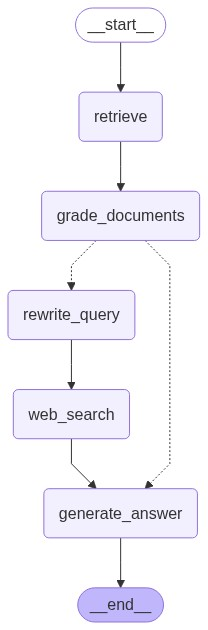

In [77]:
from IPython.display import display, Image

display(Image(agentic_rag.get_graph().draw_mermaid_png()))

test

In [56]:
query = "what is the capital of India?"

RESPONSE = agentic_rag.invoke({"question": query})


 Entered: retrieve
Question: what is the capital of India?
 Total docs in vectorstore: 6
 Retrieved 5 documents

 Doc #1 (hash: a7c8efadf5ba88c7450583882c41c876)
Central India is an Indian region.Central India consists of two Indian states: Madhya Pradesh and Chhattisgarh. It shares a border with Rajasthan, Gujarat, Odisha, Jharkhand, Uttar Pradesh, Maharashtra and Telangana. Both the states are ruled by the Congress with Chief Ministers andThis map of India
 Metadata: {'article_id': '731169', 'title': 'Central India'}

 Doc #2 (hash: 972b492cdfacbd67516592dbdb8c2b7a)
The Republic of India is divided into twenty-eight States,and eight union territories including the National Capital Territory.
 Metadata: {'article_id': '22215', 'title': 'States and union territories of India'}

 Doc #3 (hash: 37f9e7187fcca99fa1e85934885fa654)
Chhattisgarh is a state within the Republic of India. It occupies . In traditional Indian geography it falls under the East Indian zone.The capital at present is

In [52]:
from IPython.display import display, Markdown
display(Markdown(RESPONSE["generation"]))

 The capital of India is New Delhi.

In [79]:
query = "Who won the champions league in 2024?"

RESPONSE = agentic_rag.invoke({"question": query})


Entered: retrieve
Question: Who won the champions league in 2024?
Total docs in vectorstore: 6
Retrieved 5 documents

Doc #1 (hash: c2e9ebed4a718d03980158fce8f7eae5)
The World Series in Major League Baseball, is when the best team from the American League (the winner of the American League Championship Series) and the best team from the National League (the winner of the National League Championship Series) keep playing games of baseball until one of the two tea
Metadata: {'article_id': '26645', 'title': 'World Series'}

Doc #2 (hash: 901098c1d65c9352a7a65e5cfb9d8153)
The Monaco Grand Prix (Grand Prix de Monaco) is a Formula One race held each year on the Circuit de Monaco. Run since 1929, it is widely considered to be one of the most important and prestigious automobile races in the world alongside the Indianapolis 500 and the 24 Hours of Le Mans."Drivers in bol
Metadata: {'article_id': '61480', 'title': 'Monaco Grand Prix'}

Doc #3 (hash: decb95308a9058b8574c3959680867c0)
Super Bowl 

In [80]:
from IPython.display import display, Markdown
display(Markdown(RESPONSE["generation"]))

Real Madrid won champions league in 2024


In [81]:
query = "Tell me about India"

RESPONSE = agentic_rag.invoke({"question": query})



 Entered: retrieve
Question: Tell me about India
 Total docs in vectorstore: 6
 Retrieved 5 documents

 Doc #1 (hash: 37e81700e87637307ad42fb1ac0eb15f)
Indian or Indians can refer to:
 Metadata: {'article_id': '264544', 'title': 'Indian'}

 Doc #2 (hash: 7274d80011f8184a351f6529eeded64a)
India has 23 official languages. The its constitution lists the name of the country in each of the languages. Hindi and English (listed in boldface) are the "official languages of the union" (Union meaning the Federal Government located in Delhi); Tamil and Sanskrit are officially the "classical lan
 Metadata: {'article_id': '121918', 'title': 'Official names of India'}

 Doc #3 (hash: c45964febc2d9b051462116b36cbec07)
East India is a region of the Republic of India. It includes the states of Bihar, Chhattisgarh, Jharkhand, Orissa and West Bengal. The states of Orissa and West Bengal share some cultural and linguistic characteristics with Bangladesh and with the state of Assam. Together with Banglades

In [82]:
display(Markdown(RESPONSE["generation"]))

 India is a country located in Asia with an area of approximately 3.2 million square kilometers. It is the seventh largest country in the world by area and the most populous democracy in the world with over 1.2 billion people. The official languages of the union are Hindi and English, while Tamil and Sanskrit are classified as classical languages. India has seven neighbors, including Pakistan, China, Nepal, Bhutan, Bangladesh, Myanmar, and Sri Lanka. The capital of India is New Delhi, and it is a peninsula bounded by the Indian Ocean, Arabian Sea,